In [180]:
import yfinance as yf
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense

# Load data

In [145]:
ticker = 'AAPL'
data_train = yf.download(ticker, start='2015-01-01', end='2024-03-01')
data_test = yf.download(ticker, start='2024-03-01', end='2024-06-30')
data = pd.concat([data_train, data_test]).reset_index()
full_data = data.copy()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [146]:
# data_train.to_csv(rf'C:\Users\MY PC\Project\data\{ticker}_stock_train.csv')
# data_test.to_csv(rf'C:\Users\MY PC\Project\data\{ticker}_stock_test.csv')
# full_data.to_csv(rf'C:\Users\MY PC\Project\data\{ticker}_stock.csv')

In [147]:
min_time = pd.to_datetime(full_data["Date"]).min().strftime('%Y-%m-%d')
max_time = pd.to_datetime(full_data["Date"]).max().strftime('%Y-%m-%d')
print(min_time)
print(max_time)

2015-01-02
2024-06-28


In [148]:
full_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687305,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021713,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944689,237458000


In [149]:
full_data['Date'] = pd.to_datetime(full_data['Date'])

In [150]:
full_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687305,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021713,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944689,237458000


In [151]:
print(f"Length of full data: {len(full_data)}")
print(f"Length of train data: {len(data_train)}")
print(f"Length of test data: {len(data_test)}")

Length of full data: 2388
Length of train data: 2305
Length of test data: 83


Notes:
- Determine that this is multivariate time series forecasting
- Good models: ARIMA, LSTM, gradient boosting, try out TTMs
- liquid neural network?
- "Close" is the target, used for predictions

# Preprocessing

### OHLCV graph with plotly

In [152]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.1, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.4, 0.7])

fig.add_trace(go.Ohlc(x=full_data['Date'],
				open=full_data['Open'],
				high=full_data['High'],
				low=full_data['Low'],
				close=full_data['Close'],
				showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=full_data['Date'], 
                         y=full_data['Volume'], 
                         mode='lines',
                         line=dict(color='blue', width=0.7),
						 showlegend=False, 
                         name='Volume'), row=2, col=1)

fig.update_layout(
    autosize=False,
    width=1100,
    height=900,
    title='OHLC and Volume of AAPL stock from January 2015 to June 2024',
    xaxis1_rangeslider_visible=False,
    xaxis2_rangeslider_visible=False,
)

fig.show()

### Check for non-stationarity
- Try the Augmented Dickey Fuller (ADF) test:
	- If p-value > 0.05, then data is not stationary (most stock prices aren't stationary)
- Autocorrelation Function (ACF) plot to resolve this
- For ARIMA, it's best to notice the optimal p, q and d:
	- d represents the number of differencing operations needed to make the time series stationary.
	- p is the number of lag observations included in the model (AutoRegressive part).
	- q is the number of lagged forecast errors in the prediction equation (Moving Average part).
- Reference: https://www.youtube.com/watch?v=gqryqIlvEoM&ab_channel=DecisionForest

In [153]:
returns = adfuller(full_data["Close"].dropna())
print(f"ADF statistics: {returns[0]}")
print(f"p-value: {returns[1]}")      # p-value > 0.05, so the data is not stationary

ADF statistics: 0.23769101945182308
p-value: 0.9742980823824576


### Plot ACF

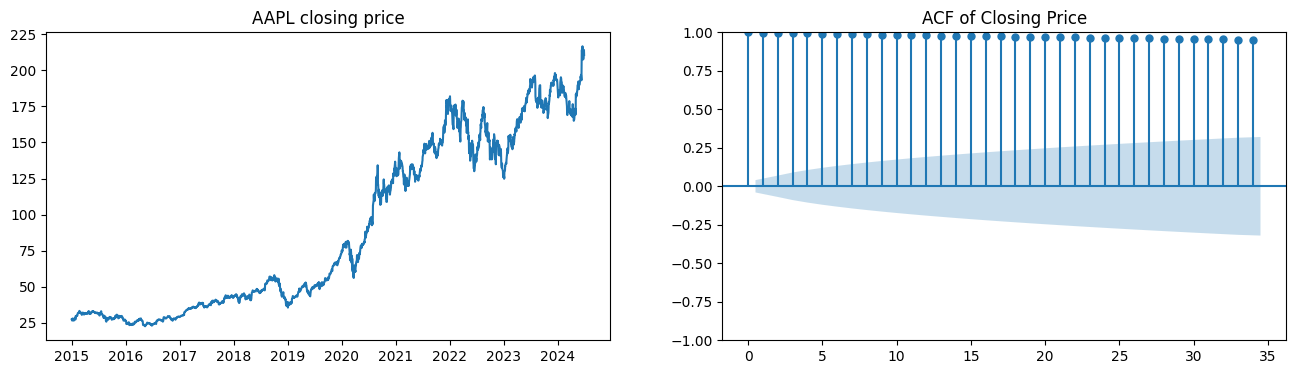

In [154]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(full_data['Date'], full_data['Close'])
ax1.set_title('AAPL closing price')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plot_acf(full_data['Close'], ax=ax2)
ax2.set_title('ACF of Closing Price')  # a slow decrease to 0 indicates that the data is not stationary
plt.show()

In [155]:
# order of differencing
ndiff = ndiffs(full_data['Close'], test='adf')  # ndiff = 1 here, ndiff = d

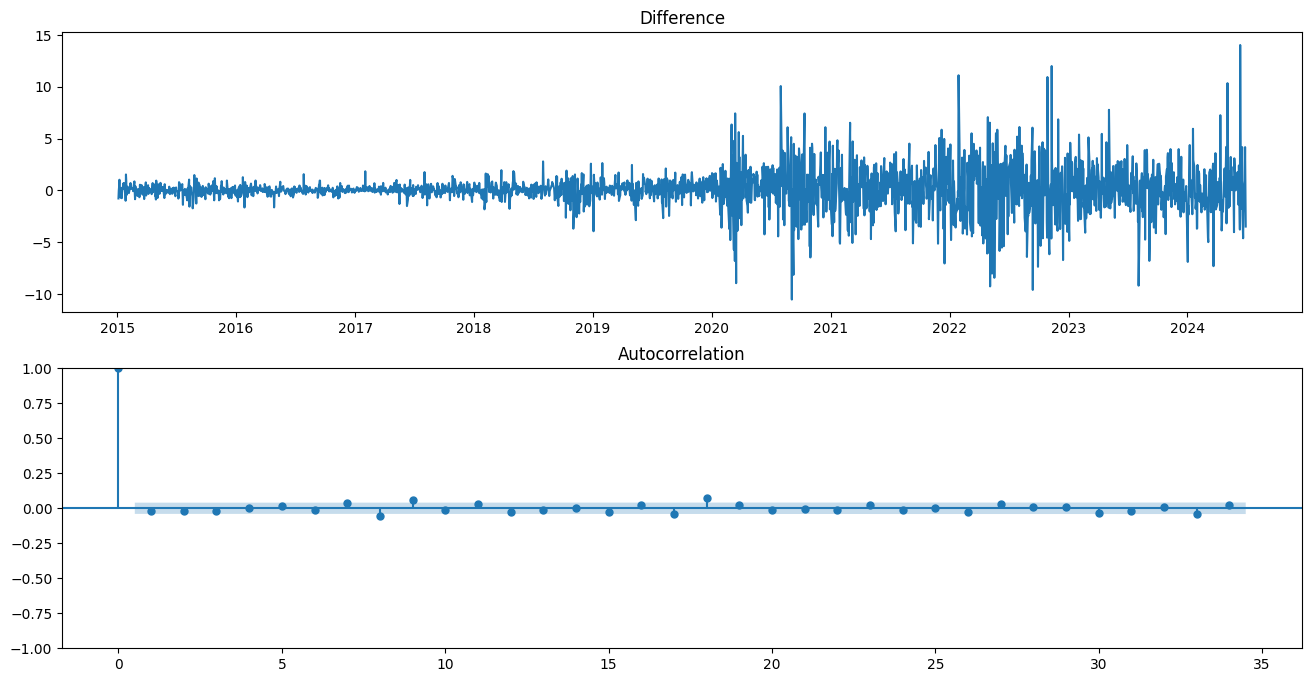

In [156]:
for _ in range(ndiff):
	diff = full_data['Close'].diff().dropna()

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
ax1.plot(full_data['Date'][1:], diff)
ax1.set_title('Difference')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plot_acf(diff, ax=ax2)
ax2.set_title('Autocorrelation')

plt.show()

### Check difference again for stationarity & optimal d

In [166]:
after_diff = adfuller(diff)
print(f"ADF statistics: {after_diff[0]}")
print(f"p-value: {after_diff[1]}") # p-value < 0.05, so the data is now stationary
print(f"Number of differencing/ Optimal d: {ndiff}")

ADF statistics: -10.49816655443856
p-value: 1.1015930387679366e-18
Number of differencing/ Optimal d: 1


### Find optimal p

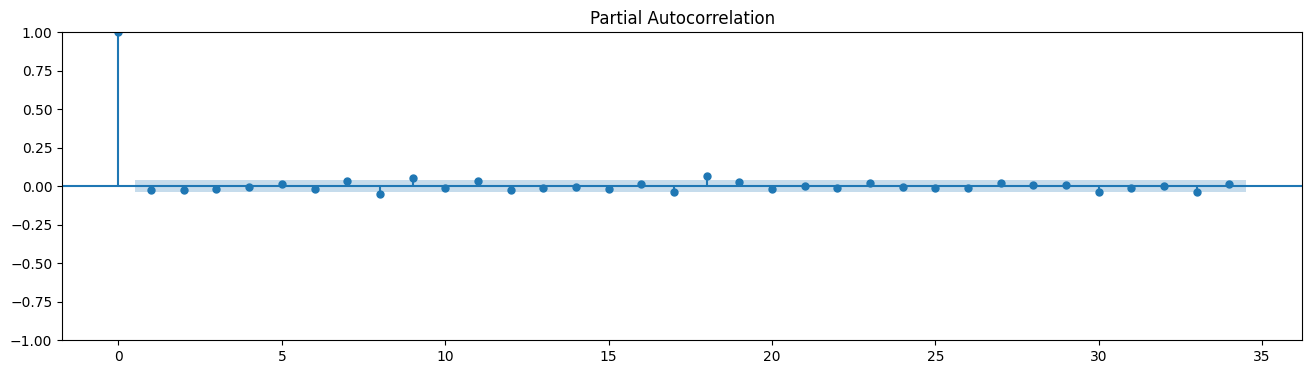

In [184]:
diff_p = full_data["Close"].diff().dropna()
_, ax = plt.subplots(1, 1, figsize=(16, 4))
plot_pacf(diff_p, ax=ax)
ax.set_title('Partial Autocorrelation')

plt.show()

# observation: p = 0

### Find optimal q

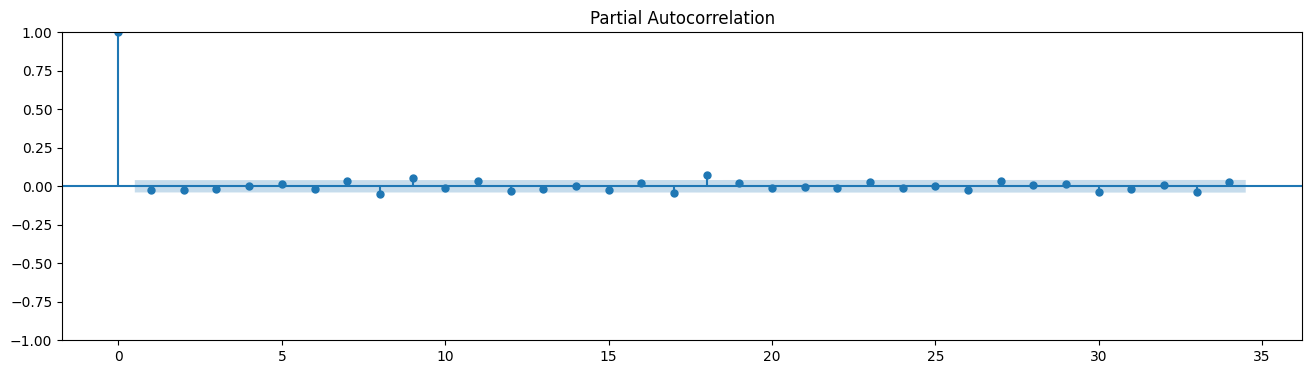

In [187]:
diff_q = full_data["Close"].diff().dropna()
_, ax = plt.subplots(1, 1, figsize=(16, 4))
plot_acf(diff_q, ax=ax)
ax.set_title('Partial Autocorrelation')

plt.show()

# observation: q = 0

#### summary

In [189]:
y = full_data['Close']

# Fit the ARIMA model automatically to find the best p, d, q
auto_arima_model = auto_arima(y, start_p=0, start_q=0, max_p=5, max_q=5, 
                      seasonal=False,
                      stepwise=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9819.801, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9820.553, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9820.493, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9821.733, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.744 seconds


### Correlation matrix

In [163]:
full_data['Diff_Close'] = full_data['Close'].diff()  # Differenced closing price
full_data['MA_10'] = full_data['Close'].rolling(window=10).mean()  # 10-day moving average
full_data['MA_30'] = full_data['Close'].rolling(window=30).mean()  # 30-day moving average
full_data.dropna(inplace=True)

In [164]:
full_data

,Date,Open,High,Low,Close,Adj Close,Volume,Diff_Close,MA_10,MA_30
30,2015-02-17,31.872499,32.220001,31.730000,31.957500,28.610807,252609600,0.187500,30.626750,28.726667
31,2015-02-18,31.907499,32.195000,31.862499,32.180000,28.810001,179566800,0.222500,30.878500,28.913917
32,2015-02-19,32.119999,32.257500,32.082500,32.112499,28.749578,149449600,-0.067501,31.100750,29.098833
33,2015-02-20,32.154999,32.375000,32.012501,32.375000,28.984591,195793600,0.262501,31.339750,29.280083
34,2015-02-23,32.505001,33.250000,32.415001,33.250000,29.767948,283896400,0.875000,31.691500,29.456000
...,...,...,...,...,...,...,...,...,...,...
2383,2024-06-24,207.720001,212.699997,206.589996,208.139999,207.899353,80727000,0.649994,209.634000,197.103999
2384,2024-06-25,209.149994,211.380005,208.610001,209.070007,208.828293,56713900,0.930008,211.229001,197.971332
2385,2024-06-26,211.500000,214.860001,210.639999,213.250000,213.003448,66213200,4.179993,211.839001,198.870332
2386,2024-06-27,214.690002,215.740005,212.350006,214.100006,213.852478,49772700,0.850006,211.942001,199.759333


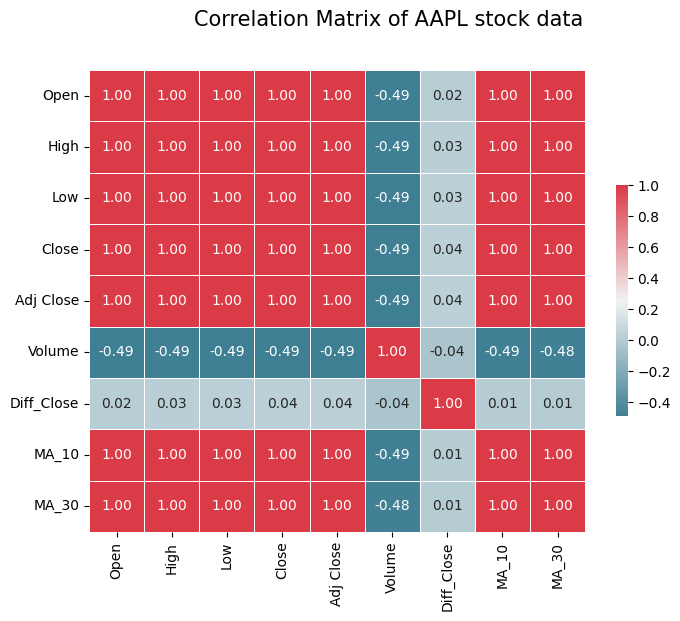

In [165]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', "Diff_Close", "MA_10", "MA_30"]
def correlation_matrix(df, numeric_cols):
    """
    Plot correlation heatmaps of the target variable against all other variables for each category.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))  # Fixed variable name `ax`

    corr = df[numeric_cols].corr()
    
    sns.heatmap(
        corr,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        ax=ax,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )
    
    plt.suptitle('Correlation Matrix of AAPL stock data', fontsize=15)
    plt.show()

correlation_matrix(full_data, num_cols)

## Stock prediction with ARIMA

### Build ARIMA model with p = 0, d = 1, q = 0

In [161]:
def get_arima_forecasts(df, cat_col, formatted_date, target_col,
                        start_date, end_date, context_len=64):
    """
    Forecast stock value with ARIMA

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    cat_col (str): The column name for categories.
    formatted_date (str): Date column name.
    target_col (str): The target variable to correlate with other variables.
    start_date (str): Lower bound for normal data
    end_date (str): Upper bound for normal data. Normal data is used as training
    resource for ARIMA model
    context_len (int, Default=64): number of points to make prediction on

    Returns: a dictionary containing 'train_data','test_data',
    'forecasts', 'actuals', 'timestamps' (date) and 'forecast_timestamps'

    """

    def get_arma_forecast(context, p=1, r=0, q=0):
        arma = ARIMA(context, order=(p, r, q)).fit(
            method_kwargs={"warn_convergence": False}
        )
        predict_cat = arma.predict(len(context), len(context))
        return predict_cat

    df[formatted_date] = pd.to_datetime(df[formatted_date])
    cats = list(df[cat_col].unique())

    predictions = {}

    # Extract normal data
    normal_data = df[
        (df[formatted_date] >= start_date) & (df[formatted_date] <= end_date)
    ]

    for x in cats:
        sep_df = df[df[cat_col] == x]

        # Prepare data for scaling
        train_data = normal_data[normal_data[cat_col] == x][[target_col]].values

        # Scale the data using the same scaler for training and test data
        scaler = StandardScaler()
        scaled_train_data = scaler.fit_transform(train_data)

        # Prepare test data
        test_data = df[(df[formatted_date] > end_date) & (df[cat_col] == x)][
            [target_col]
        ].values
        scaled_test_data = scaler.transform(test_data)

        forecast_len = 1  # Predicting the next value

        arma_summary = []

        for idx in range(len(scaled_test_data) - context_len - forecast_len + 1):
            context = scaled_test_data[idx : idx + context_len]
            actual = scaled_test_data[
                idx + context_len : idx + context_len + forecast_len
            ]
            forecast = get_arma_forecast(context)
            arma_summary.append((context, actual, forecast))

        # Extract actual and forecast values
        arma_actual = [i[1][0] for i in arma_summary]
        arma_forecast = [i[2][0] for i in arma_summary]

        # Inverse transform the scaled data for evaluation
        inv_train_data = scaler.inverse_transform(scaled_train_data)
        inv_test_data = scaler.inverse_transform(scaled_test_data)
        inv_arma_forecast = scaler.inverse_transform(
            np.array(arma_forecast).reshape(-1, 1)
        )

        predictions[x] = {
            "train_data": inv_train_data,
            "test_data": inv_test_data,
            "forecasts": inv_arma_forecast,
            "actuals": arma_actual,
            "timestamps": sep_df[formatted_date],
            "forecast_timestamps": sep_df[formatted_date][
                len(train_data)
                + context_len : len(train_data)
                + context_len
                + len(arma_forecast)
            ],
            cat_col: x,
        }

        # Calculate and print MSE
        if len(arma_actual) > 0 and len(arma_forecast) > 0:
            actual_array = np.array(arma_actual)
            forecast_array = np.array(arma_forecast)
            mape = np.mean(np.abs(actual_array - forecast_array / actual_array))
            print(f"MSE for {x}: {np.round(mse(arma_actual, arma_forecast), 5)}")
            print(f"MAD for {x}: {sm.robust.scale.mad(arma_forecast)}")
            print(f"MAPE for {x}: {mape * 100:.2f}%")
        else:
            raise ValueError(
                "No forecasts were generated. Check your data and sliding window configuration."
            )

    return pd.DataFrame(predictions)

### Metrics